# Sensitivity Analysis
There are two types of sensitivity analysis:
1. **Local sensitivity analysis (LSA)**: Performed by varying uncertain model parameters around specific (initial) values. 
    * The goal is to explore how small changes in input variables influence changes in model output.    
    * Assumes that input variables are independent (they do not interact).
    * If this assumption is false, LSA may underestimate the influence that the inputs have on output metrics.    
    * E.g. One-at-a-time analysis 
2. **Global sensitivity analysis (GSA)**: Performed by varying uncertain model input within the entire feasible space of potential input values. 
   * Reveals the global and interactive effects of each input variable on model output.
   * *Variance-based GSA*: Analysis of model output variance can determine how sensitive it is to its input variables (e.g. Sobol SA, Analysis of Variance (ANOVA))
   * *[Moment-independent GSA](https://waterprogramming.wordpress.com/2020/05/18/information-theory-and-moment-independent-sensitivity-indices/)*: Compares entire unconditional and conditional probability distributions of input variables and model output values to determine model sensitivity to an input variable (e.g. Delta Moment-Independent SA, Pianosi and Wagener method (PAWN))

More information on sensitivity analysis and why we perform it can be found [here](https://uc-ebook.org/docs/html/3_sensitivity_analysis_the_basics.html).

## Import the key libraries
Let's begin by importing some key libraries. Some might look familiar, with the exception of SALib. SALib is a Python library that contains commonly-used sensitivity analysis method and useful uncertainty sampling functions. You can install the library [here](https://github.com/SALib/SALib) by cloning the Git repository, or by entering `pip install SALib` into your command line.

In [24]:
# import function to generate uncertainty samples within a specified range using the Saltelli sampling scheme
from SALib.sample import saltelli   
# import function to perform different types of sensitivity analysis
from SALib.analyze import sobol
from SALib.analyze import delta
# import all other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now we load the two TBW Financial Model files we'll likely need later:

In [72]:
# list of objective and decision variable names
obj_names = ["sim_id", "debt_cov_violation_freq", "rate_cov_violation_freq", "peak_uniform_rate"]
dv_names = ["cov_threshold", "debt_covenant_req_ratio", "unencum_budget_frac", "mngd_uniform_rate_incr",
           "mngd_uniform_rate_decr", "prev_unacc_ent_fund_frac", "debtservice_cap_frac", "rr_fund_frac", "fip_fund_frac",
           "energy_fund_frac", "reserve_fund_frac"]

tbw_objectives = pd.read_csv("Objectives_f125.csv")
tbw_dvs = pd.read_csv("financial_model_DVs.csv", names=dv_names)
tbw_objectives = tbw_objectives.drop(columns=["Simulation ID","Rate Covenant Violation Frequency"])
tbw_objectives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         100 non-null    int64  
 1   Debt Covenant Violation Frequency  100 non-null    float64
 2   Peak Uniform Rate                  100 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


## The model
Here we define an arbitrary model to demonstrate how OAT and Sobol SA work.

In [56]:
# define an arbitrary model
def just_a_random_model(a, b, x1, x2, x3):
    """
    A random model with nonlinear input variable interactions
    Parameters
    ----------
    a, b : floats
        Model constants
    x1, x2, x3: floats
        Model input variables
    
    -------
    Returns the model output
    """
    return np.sin(x1) + (a*(np.sin(x2)**2)) + (b*(x3**4)*np.sin(x1))


## One-at-a-Time (OAT) Sensitivity Analysis
OAT is essentially a finite-difference estimate where the sensitivity of each factor $x_i$ is quantified as follows:
$$S_i = \frac{\Delta y}{\Delta x_i}$$
for some small $\Delta x_i$.

For example, if this random model's initial point is $(x_1,x_2,x_3) = (1.0,1.0,1.0)$, we can find the sensitivity indices using $\Delta x_i=0.01$ for each variable.

In [11]:
# assign a, b random values
a, b = 7, 0.1

# Initialize x1, x2, x3 with 1.0,1.0,1.0
x1, x2, x3 = 1.0,1.0,1.0

# the small change in decision variables
delta = 0.01

# initial model output
y_init = just_a_random_model(a, b, x1, x2, x3)

# Sensivity to x1
S1 = abs(just_a_random_model(a, b, x1+delta, x2, x3) - y_init)/delta
# Sensivity to x2
S2 = abs(just_a_random_model(a, b, x1, x2+delta, x3) - y_init)/delta
# Sensivity to x2
S3 = abs(just_a_random_model(a, b, x1, x2, x3+delta) - y_init)/delta

print("Sensivity to x1 = {}".format(S1))
print("Sensivity to x2 = {}".format(S2))
print("Sensivity to x3 = {}".format(S3))

Sensivity to x1 = 0.5896945791130648
Sensivity to x2 = 6.335528349905317
Sensivity to x3 = 0.34167096281851883


## Sobol Sensivity Analysis
Sobol SA is one of the most popular [variance-based global SA methods](https://uc-ebook.org/docs/html/3_sensitivity_analysis_the_basics.html#variance-based-methods). It calculates three types of sensitivity indices:

**First-order**: Measures the percent of model output variance contributed by a factor *individually*.
$$S_{i}^{1} = \frac{V_{x_i}[\mathbb{E}_{x\sim i}(x_i)]}{V_y}$$

**Second-order**: Indicates how interactions between *pairs* of factors can lead to change in model output variance (here $i \neq j$).
$$S_{ij}^{2} = \frac{V_{x_{i,j}}[\mathbb{E}_{x\sim i,j}(x_i,x_j)]}{V_y}$$

**Total-order**: Represents the entire influence of an input variable/factor/parameter on model outputs and captures the full individual and interactive effects of all input variables. It reveals the expected portion of variance that remains if uncertainty is eliminated in all factors *but* $x_i$.
$$S_{i}^{T} = \frac{\mathbb{E}_{x\sim i}[V_{x_i}(x_{\sim i})]}{V_y} = 1 - \frac{V_{x_i}[\mathbb{E}_{x\sim i}(x_i)]}{V_y}$$


In [17]:
# define the problem, the number of input variables, their names in the function
# and their range of uncertainty
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}

# Generate 1000 decision variable samples using the Saltelli method 
param_values = saltelli.sample(problem, 1000)

# generate 1000 model output in response to the param_values
Y = np.zeros(1000, dtype=float)

for i in range(1000):
    Y[i] = just_a_random_model(a, b ,param_values[i,0], param_values[i,1], param_values[i,2])

# use the Sobol method to perform sensitivity analysis
S_indices = sobol.analyze(problem, Y, print_to_console=True)

          ST   ST_conf
x1  0.526425  0.221680
x2  0.422357  0.129704
x3  0.224151  0.069651
          S1   S1_conf
x1  0.322026  0.178506
x2  0.413205  0.156982
x3  0.031402  0.194091
                S2   S2_conf
(x1, x2)  0.006910  0.236805
(x1, x3)  0.211317  0.295642
(x2, x3)  0.004740  0.182976


C:\Users\lbl59\Anaconda3\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


In [ ]:
# try to formulate the TBW decision variable problem here

# ---------------------------------------

## A note on sampling 
There are multiple ways to sample from decision variable uncertainty ranges. Three examples are:
1. **Monte Carlo (purely random) sampling**: Computationally expensive (inefficient), prone to "lumpiness".
2. **[Latin Hypercube Sampling (LHS)](https://uc-ebook.org/docs/html/3_sensitivity_analysis_the_basics.html#latin-hypercube-sampling-lhs)**: For $N$-uncertain input variables, an $N$-dimensional hypercube is generated. Guarantees sampling from every $N$-level. 
3. **[Sobol sampling](https://uc-ebook.org/docs/html/3_sensitivity_analysis_the_basics.html#low-discrepancy-sequences)**: May result in smaller error and faster convergence (more efficient), useful for models with a large number of DVs and model outputs (objectives). Ensures the same number of samples in any subspace of the $N$-hypercube.

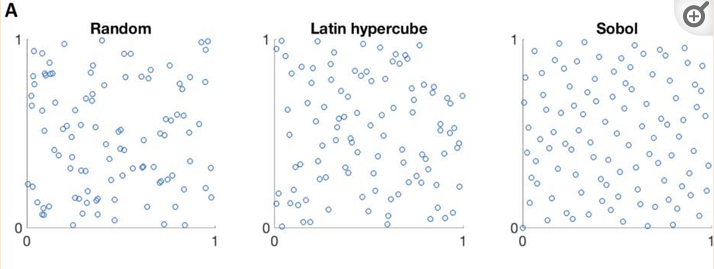
The distribution of uncertain input variable samples for each sampling method [[source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8184610/#S22title)].

## Delta ($\delta$) Moment-Independent Sensitivity Analysis
Moment-independent methods compare the *entire distribution* of input and output parameters to determine the sensitivity of the model output to a specific input variable. They are therefore independent of statistical moments (mean, standard deviation, etc). 

Specifically, the [$\delta$ moment-independent SA method](https://uc-ebook.org/docs/html/3_sensitivity_analysis_the_basics.html#moment-independent-density-based-methods) calculates the difference between the conditional and unconditional *cumulative* distribution functions of the output. It is defined as:
$$S_i = \delta_i = \frac{1}{2}\mathbb{E}|f_y(y) - f_{y|x_i}(y)|dy$$

This equation calculates the area between the output probability density function $f_(y)$ and the conditional density of $y$ given $x_i$, $f_{y|x_i}(y)$, as visualized in the figure below [[source](https://onlinelibrary.wiley.com/doi/10.1111/j.1539-6924.2006.00806.x)].
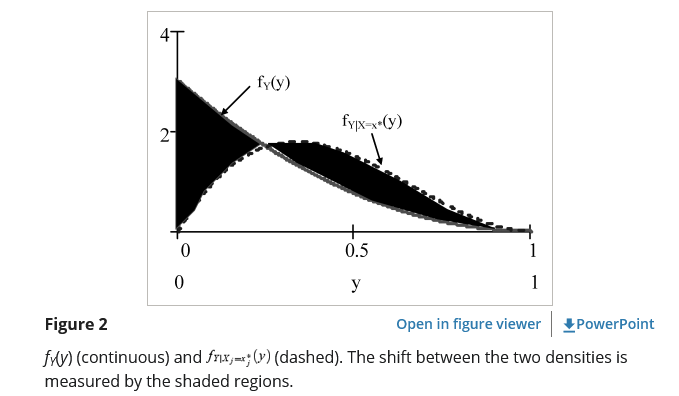

The value of $\delta_i$ therefore represents the normalized expected shift in the probability distribution of $y$ induced by $x_i$. This is a useful approach for cases in which you would like to better analyze the impacts of extreme events in a system. However, it does not include interactions *between* factors, but can be modified to do so by including more uncertain input variables when conditioning the model output $y$. 

The begin, we first define a few functions that will help us pre-process our financial model prior to performing $\delta$ moment-independent SA. Let's also create a subfolder called `delta_output`.

In [74]:
def find_bounds(input_file):
    """
    Finds the founds of the decision variables.
    Parameters
    ----------
    input_file : numpy matrix
        A numpy matrix that specifies the lower and upper bounds of each decision
        variable or DU factor multiplier.
    Returns
    -------
    bounds : tuple
        The lower and upper bound of a decision variable.
    """
    bounds = np.zeros((input_file.shape[1],2), dtype=float)
    for i in range(input_file.shape[1]):
        bounds[i,0] = min(input_file[:,i])
        bounds[i,1] = max(input_file[:,i])

    return bounds

In [75]:
def delta_sensitivity(dv_dataframe, objs_dataframe, bounds):
    """
    Main function that performs Delta moment-independent sensitivity analysis
    Writes a csv file to a subfolder named 'delta_output/S1_[objs].csv'
    
    Parameters
    ----------
    dv_dataframe : pandas dataframe
        Contains the float values of the decision variables.
    objs_dataframe : pandas dataframe
        Contains the float values of the model performance objectives.
    bounds : numpy matrix
        An (len(dv_dataframe) x 2) matrix of the lower and upper bounds of the decision variables.
    
    Returns
    -------
    None.
    """
    
    # Get names of all relevant decision variables
    dv_names = dv_dataframe.columns
    obj_names = objs_dataframe.columns
    
    X = dv_dataframe.to_numpy()
    Y = objs_dataframe.to_numpy()

    problem = {
        'num_vars': int(X.shape[1]),
        'names': dv_names,
        'bounds': bounds
    }
    
    for i in range(Y.shape[1]):     
        obj_label = obj_names[i]
        #print('obj: ', obj_label)
        
        filename = 'delta_output/S1_' + obj_label + '.csv'
        S1 = delta.analyze(problem, X, Y[:,i], num_resamples=1, conf_level=0.95, print_to_console=False)
        numpy_S1 = np.array(S1["S1"])
        fileout = pd.DataFrame([dv_names, numpy_S1], index = None, columns = None)
        fileout.to_csv(filename, sep=",")

In [76]:
'''
Get bounds for model DVs
'''
dv_bounds = find_bounds(tbw_dvs.to_numpy())
delta_sensitivity(tbw_dvs, 
                  tbw_objectives, 
                  dv_bounds)
                        

C:\Users\lbl59\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\lbl59\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [77]:
def compile_obj_sensitivity(dv_names, objs_labels, output_file_name):
    """
    Writes a csv file that contains the delta sensitivity indices for 
    each decision variable across all objectives.
    
    Parameters
    ----------
    dv_names : list
        Contains the names of the model decision variables.
    objs_labels : list
        Contains the names of the model performance objectives.
    output_file_name : string
        The name of the output file
    
    Returns
    -------
    None.
    """
    s1_dv_objs = np.zeros((len(objs_labels), len(dv_names)), dtype=float)
    #obj_labels = ["Debt Covenant Violation Frequency","Peak Uniform Rate"]

    for i in range(len(objs_labels)):
        curr_file = 'delta_output/S1_' + objs_labels[i]+'.csv'
        s1_dv_objs[i, :] = pd.read_csv(curr_file, sep=',', skiprows=2, header=None).iloc[0, 1:]

    s1_df = pd.DataFrame(s1_dv_objs, columns=dv_names)
    out_file_name = output_file_name + '.csv'
    s1_df.to_csv(out_file_name, sep=',', index=False)
    

obj_labels = ["Debt Covenant Violation Frequency","Peak Uniform Rate"]
compile_obj_sensitivity(dv_names, obj_labels, "delta_indices")

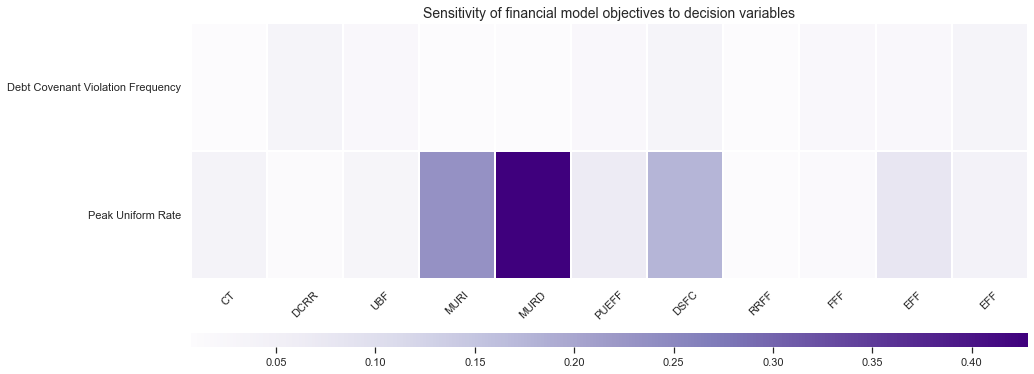

In [90]:
import seaborn as sns

sns.set_theme()
cmap_col = 'Purples'
rot = 45 

# decision variable names are abbreviations
y_objs = obj_labels
x_dvs = ["CT", "DCRR", "UBF", "MURI", "MURD", "PUEFF", "DSFC", "RRFF", "FFF", "EFF", "EFF"]

si_file = pd.read_csv("delta_indices.csv", index_col=False)
savefig_name = 'delta_sensitivity_indices'

# Begin plotting
grid_kws = {"height_ratios": (0.90, .05), "hspace": 0.4}
f, (ax1, cbar_ax) = plt.subplots(2, figsize=(15, 5), gridspec_kw=grid_kws)
plt.subplots_adjust(top = 0.95, bottom = 0.05, hspace = 0, wspace = 0.05)

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=12)

title = 'Sensitivity of financial model objectives to decision variables'
ax1.set_title(title, size=14)
ax1 = sns.heatmap(si_file, linewidths=.05, cmap=cmap_col, xticklabels=x_dvs, yticklabels=y_objs, ax=ax1, cbar=True,
                  cbar_ax = cbar_ax, cbar_kws = {'orientation': 'horizontal'})
ax1.set_yticklabels(y_objs, rotation=0)
ax1.set_xticklabels(x_dvs, rotation=rot, ha='center')

cbar_kws={'orientation': 'horizontal'}
plt.savefig(savefig_name)
plt.show()